
# 📗 Notebook 1 — Data Exploration and Preparation (2015–2025)

This notebook performs **data ingestion, cleaning, and exploratory analysis** for the EU hotel demand forecasting project.  
It builds a consistent, reliable dataset used in subsequent modeling notebooks.

---

### **Structure Overview**

0. Environment Setup  
1. Load and Inspect Interim Data  
2. Integrity Checks  
3. Order and Inspect Columns  
4. Imputation and Final Fixes  
5. Exploratory Data Analysis (EDA)  
6. Variable Transformations 
7. Save Clean Dataset and EDA Summary  

---

**Input:**  
📁 `../data/interim/hotel.csv`

**Output:**  
📁 `../outputs/figures/correlation_heatmap_within_vs_raw.png`  
📁 `../data/processed/hotel_clean.csv`

In [1]:
# %% ===============================================================
# STEP 0 — ENVIRONMENT SETUP
# ===============================================================
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import math
import matplotlib.dates as mdates
import warnings

warnings.filterwarnings("ignore")

plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("viridis")

BASE_DIR = Path("..")
DATA_INTERIM = BASE_DIR / "data" / "interim"
DATA_PROCESSED = BASE_DIR / "data" / "processed"
OUTPUTS = BASE_DIR / "outputs"
FIGURES = OUTPUTS / "figures"

for path in [DATA_INTERIM, DATA_PROCESSED, FIGURES]:
    path.mkdir(parents=True, exist_ok=True)

print("✅ Environment setup complete.")

✅ Environment setup complete.


In [2]:
# %% ===============================================================
# STEP 1 — LOAD AND INSPECT INTERIM DATA
# ===============================================================

DATA_PATH = DATA_INTERIM / "hotel.csv"

df = pd.read_csv(DATA_PATH, parse_dates=["month"])
df["year"] = df["month"].dt.year

print(f"✅ Dataset loaded successfully: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"✅ Time range: {df['month'].min():%Y-%m} → {df['month'].max():%Y-%m}")
print(f"✅ Regions: {df['region'].nunique()}")
df.head()

✅ Dataset loaded successfully: 3328 rows × 12 columns
✅ Time range: 2015-01 → 2025-08
✅ Regions: 26


,region,nights_spent,month,gdp,unemployment_rate,turnover_index,hicp_index,covid_cases,eurusd,eurgbp,policy_stringency,year
0,AT,1833949.0,2015-01-01,61180.5,5.5,NaN,98.48,NaN,1.128796,0.748800,NaN,2015
1,AT,2145686.0,2015-02-01,NaN,5.9,NaN,98.75,NaN,1.119796,0.726058,NaN,2015
2,AT,1934635.0,2015-03-01,NaN,5.4,NaN,100.15,NaN,1.083025,0.731200,NaN,2015
3,AT,1468507.0,2015-04-01,62509.3,5.6,NaN,100.28,NaN,1.111432,0.720400,NaN,2015
4,AT,1792973.0,2015-05-01,NaN,5.8,NaN,100.45,NaN,1.096035,0.715400,NaN,2015


In [3]:
# %% ===============================================================
# STEP 2 — INTEGRITY CHECKS
# ===============================================================
# Purpose: Validate duplicates, region codes, and monthly coverage.
# ===============================================================

# --- 1. Duplicate region–month pairs ---
dupes = df.duplicated(subset=["region", "month"]).sum()
print("✅ No duplicate region–month pairs found." if dupes == 0 else f"❌ Found {dupes} duplicate rows!")

# --- 2. Validate EU region codes ---
EU_CODES = [
    "AT","BE","BG","CY","CZ","DE","DK","EE","ES","FI","FR","HR","HU",
    "IE","IT","LT","LU","LV","MT","NL","PL","PT","RO","SE","SI","SK"
]

invalid = sorted(set(df["region"]) - set(EU_CODES))
print(f"✅ All {len(EU_CODES)} EU region codes are valid." if not invalid else f"⚠️ Invalid region codes detected: {invalid}")

# --- 3. Monthly coverage check ---
coverage = df.groupby("region")["month"].nunique()
if coverage.nunique() == 1:
    print(f"✅ Each country has {coverage.iloc[0]} monthly observations.")
else:
    print("⚠️ Uneven monthly coverage across regions.")

print(f"🗓️ Time span: {df['month'].min().date()} → {df['month'].max().date()}")

✅ No duplicate region–month pairs found.
✅ All 26 EU region codes are valid.
✅ Each country has 128 monthly observations.
🗓️ Time span: 2015-01-01 → 2025-08-01


In [4]:
# %% ===============================================================
# STEP 3 — ORDER AND INSPECT COLUMNS
# ===============================================================
# Purpose: eorder columns logically and review missing values.
# ===============================================================

# --- 1. Reorder columns logically ---
desired_order = [
    "region", "month", "year",
    "nights_spent",
    "gdp", "unemployment_rate", "turnover_index", "hicp_index",
    "covid_cases", "policy_stringency",
    "eurusd", "eurgbp"
]
remaining = [c for c in df.columns if c not in desired_order]
df = df[desired_order + remaining]

print("✅ Columns reordered logically.")
print(df.columns.tolist())

# --- 2. Summary statistics and missing values ---
df.info()
display(df.describe().T.round(2))
(df.isna().mean() * 100).round(1).sort_values(ascending=False)

✅ Columns reordered logically.
['region', 'month', 'year', 'nights_spent', 'gdp', 'unemployment_rate', 'turnover_index', 'hicp_index', 'covid_cases', 'policy_stringency', 'eurusd', 'eurgbp']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3328 entries, 0 to 3327
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   region             3328 non-null   object        
 1   month              3328 non-null   datetime64[ns]
 2   year               3328 non-null   int32         
 3   nights_spent       3292 non-null   float64       
 4   gdp                1090 non-null   float64       
 5   unemployment_rate  3328 non-null   float64       
 6   turnover_index     2634 non-null   float64       
 7   hicp_index         3328 non-null   float64       
 8   covid_cases        1456 non-null   float64       
 9   policy_stringency  936 non-null    float64       
 10  eurusd             3328 non-null   fl

,count,mean,min,25%,50%,75%,max,std
month,3328,2020-04-16 04:52:30,2015-01-01 00:00:00,2017-08-24 06:00:00,2020-04-16 00:00:00,2022-12-08 18:00:00,2025-08-01 00:00:00,NaN
year,3328.0,2019.84375,2015.0,2017.0,2020.0,2022.25,2025.0,3.083779
nights_spent,3292.0,2645446.105103,0.0,175969.5,840674.0,2193637.0,30196895.0,4765340.128618
gdp,1090.0,97927.20945,1681.0,8325.7,36183.75,90521.3,669989.9,155031.315312
unemployment_rate,3328.0,6.672386,2.0,4.6,6.0,7.7,25.1,3.238662
turnover_index,2634.0,132.179461,6.3,95.4,126.2,165.775,419.6,53.402363
hicp_index,3328.0,112.963167,96.29,101.6075,106.565,120.45,174.87,15.227927
covid_cases,1456.0,756.280179,0.0,20.557506,151.123928,743.462982,17927.075295,1698.575083
policy_stringency,936.0,40.057056,0.0,15.15125,42.049032,57.554919,95.434667,23.431209
eurusd,3328.0,1.118962,0.982956,1.084225,1.115387,1.157142,1.240957,0.051836


policy_stringency    71.9
gdp                  67.2
covid_cases          56.2
turnover_index       20.9
nights_spent          1.1
region                0.0
month                 0.0
year                  0.0
unemployment_rate     0.0
hicp_index            0.0
eurusd                0.0
eurgbp                0.0
dtype: float64

---

**Table 1.**

**Recommended Imputation Strategy** (Variable by Variable)

| Variable              | Typical missingness       | Recommended method                                                                              | Rationale                                                                                                  |
| --------------------- | ------------------------- | ----------------------------------------------------------------------------------------------- | ---------------------------------------------------------------------------------------------------------- |
| **GDP**               | 67% (quarterly → monthly) | **Linear interpolation by region**                                                              | GDP is smooth and low-frequency; linear interpolation preserves macro trend continuity.                    |
| **Turnover index**    | ~21%                      | **Group-wise linear interpolation**, optionally with *rolling median* smoothing                 | Seasonal but continuous; interpolation restores monthly continuity.                                        |
| **COVID cases**       | 56%                       | **Fill NA=0 before 2020**, **linear interpolation (2020–2024)**, then 0 again if missing after  | COVID started only in 2020; missing pre-COVID = real zeros. Some gaps in 2024–2025 can be filled smoothly. |
| **Policy stringency** | 72%                       | **Fill NA=0 before 2020**, **group-wise linear interpolation**, optional *3-month rolling mean* | Index disappeared after restrictions eased — missing = 0 (no measures).                                    |
| **Nights spent**      | ~1%                       | **Interpolate within region**, optionally *rolling mean smoothing*                              | Very few gaps; maintain natural seasonality without bias.                                                  |


In [5]:
# %% ===============================================================
# STEP 4 — IMPUTATION AND FINAL FIXES
# ===============================================================
# Purpose: Fill missing values following standard strategy.
# ===============================================================

df_clean = df.copy().sort_values(["region", "month"])

# --- GDP and turnover: interpolate within regions ---
for col in ["gdp", "turnover_index"]:
    if col in df_clean.columns:
        df_clean[col] = df_clean.groupby("region")[col].apply(lambda s: s.interpolate(limit_direction="both")).reset_index(level=0, drop=True)

# --- COVID and policy stringency: zeros before 2020, interpolate after ---
for col in ["covid_cases", "policy_stringency"]:
    if col in df_clean.columns:
        df_clean.loc[df_clean["year"] < 2020, col] = 0
        df_clean[col] = df_clean.groupby("region")[col].apply(lambda s: s.interpolate(limit_direction="both")).reset_index(level=0, drop=True)
        df_clean[col] = df_clean[col].fillna(0)

# --- Nights spent: light interpolation ---
df_clean["nights_spent"] = df_clean.groupby("region")["nights_spent"].apply(lambda s: s.interpolate(limit_direction="both")).reset_index(level=0, drop=True)

print("✅ Imputation complete.")
print(df_clean.isna().mean().sort_values(ascending=False))

✅ Imputation complete.
turnover_index       0.038462
region               0.000000
month                0.000000
year                 0.000000
nights_spent         0.000000
gdp                  0.000000
unemployment_rate    0.000000
hicp_index           0.000000
covid_cases          0.000000
policy_stringency    0.000000
eurusd               0.000000
eurgbp               0.000000
dtype: float64


In [6]:
# --- Final pass for turnover_index ---
def fill_turnover(s):
    # Interpolate normally
    s = s.interpolate(limit_direction="both")
    # If entire segment is NaN (no data at all), fill with group median
    if s.isna().all():
        s[:] = np.nan
    # Fill any remaining edge NAs using forward/backward fill
    s = s.ffill().bfill()
    # If still NA (rare), fill with overall median
    s = s.fillna(df_clean["turnover_index"].median())
    return s

df_clean["turnover_index"] = (
    df_clean.groupby("region")["turnover_index"]
    .apply(fill_turnover)
    .reset_index(level=0, drop=True)
)

print("✅ turnover_index final missing share:",
      round(df_clean["turnover_index"].isna().mean(), 4)
)

✅ turnover_index final missing share: 0.0


In [7]:
# %% ===============================================================
# STEP 5 — EXPLORATORY DATA ANALYSIS (EDA)
# Purpose: Visual overview of hotel demand trends and macro patterns.
# ===============================================================

# %% ===============================================================
# STEP 5.1 — DEFINE PANDEMIC PERIOD
# ===============================================================

def classify_period(year):
    if year < 2020:
        return "Pre-COVID"
    elif 2020 <= year <= 2022:
        return "COVID"
    else:
        return "Post-COVID"

df_clean["period"] = df_clean["year"].apply(classify_period)
df_clean["period"].value_counts()

period
Pre-COVID     1560
COVID          936
Post-COVID     832
Name: count, dtype: int64

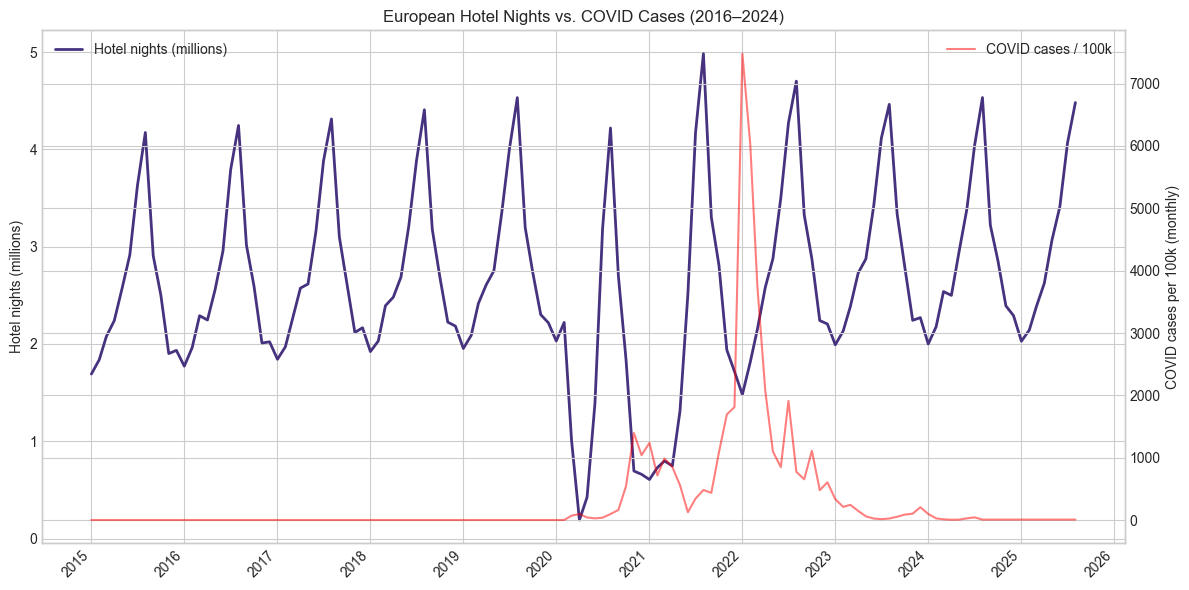

In [8]:
# %% ===============================================================
# STEP 5.2 — EU-LEVEL TRENDS
# ===============================================================

agg = (
    df_clean.groupby("month")[["nights_spent", "gdp", "unemployment_rate", "covid_cases"]]
    .mean()
    .reset_index()
)

fig, ax1 = plt.subplots(figsize=(12,6))
ax1.plot(agg["month"], agg["nights_spent"]/1e6, label="Hotel nights (millions)", linewidth=2)
ax1.set_ylabel("Hotel nights (millions)")
ax1.legend(loc="upper left")

# Twin y-axis for COVID cases
ax2 = ax1.twinx()
ax2.plot(agg["month"], agg["covid_cases"], color="red", alpha=0.5, label="COVID cases / 100k")
ax2.set_ylabel("COVID cases per 100k (monthly)")
ax2.legend(loc="upper right")

# Format x-axis to show one tick per year
ax1.xaxis.set_major_locator(mdates.YearLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.setp(ax1.get_xticklabels(), rotation=45, ha="right")

plt.title("European Hotel Nights vs. COVID Cases (2016–2024)")
plt.tight_layout()
plt.show()

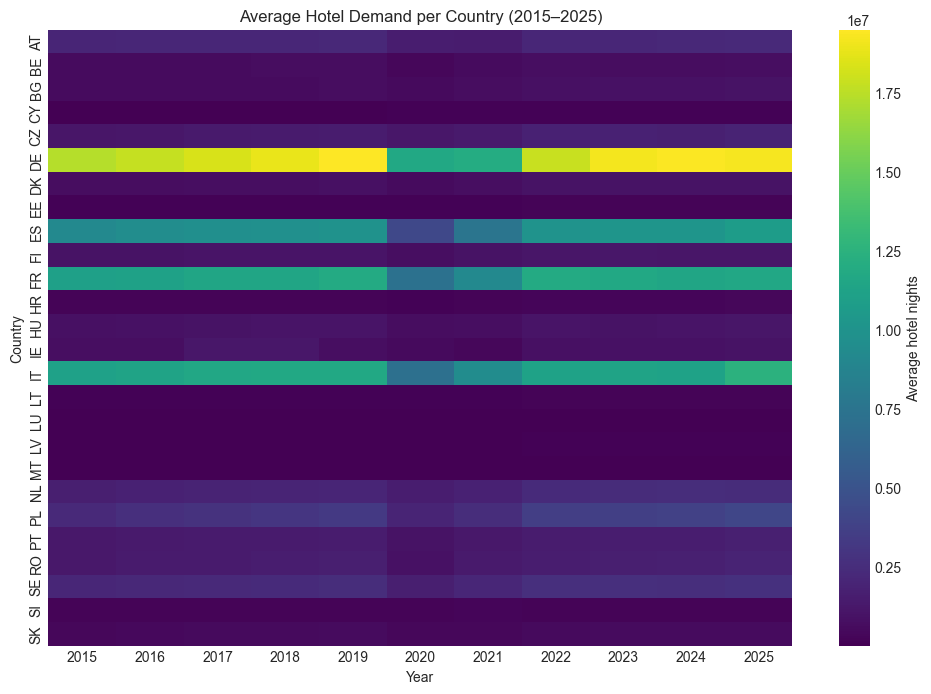

In [9]:
# %% ===============================================================
# STEP 5.3 — COUNTRY-LEVEL RECOVERY
# ===============================================================

pivot = df_clean.pivot_table(
    index="region", columns="year", values="nights_spent", aggfunc="mean"
)
plt.figure(figsize=(12,8))
sns.heatmap(pivot, cmap="viridis", cbar_kws={'label': 'Average hotel nights'})
plt.title("Average Hotel Demand per Country (2015–2025)")
plt.xlabel("Year")
plt.ylabel("Country")
plt.show()

[INFO] Plotting distributions for 9 numeric indicators.


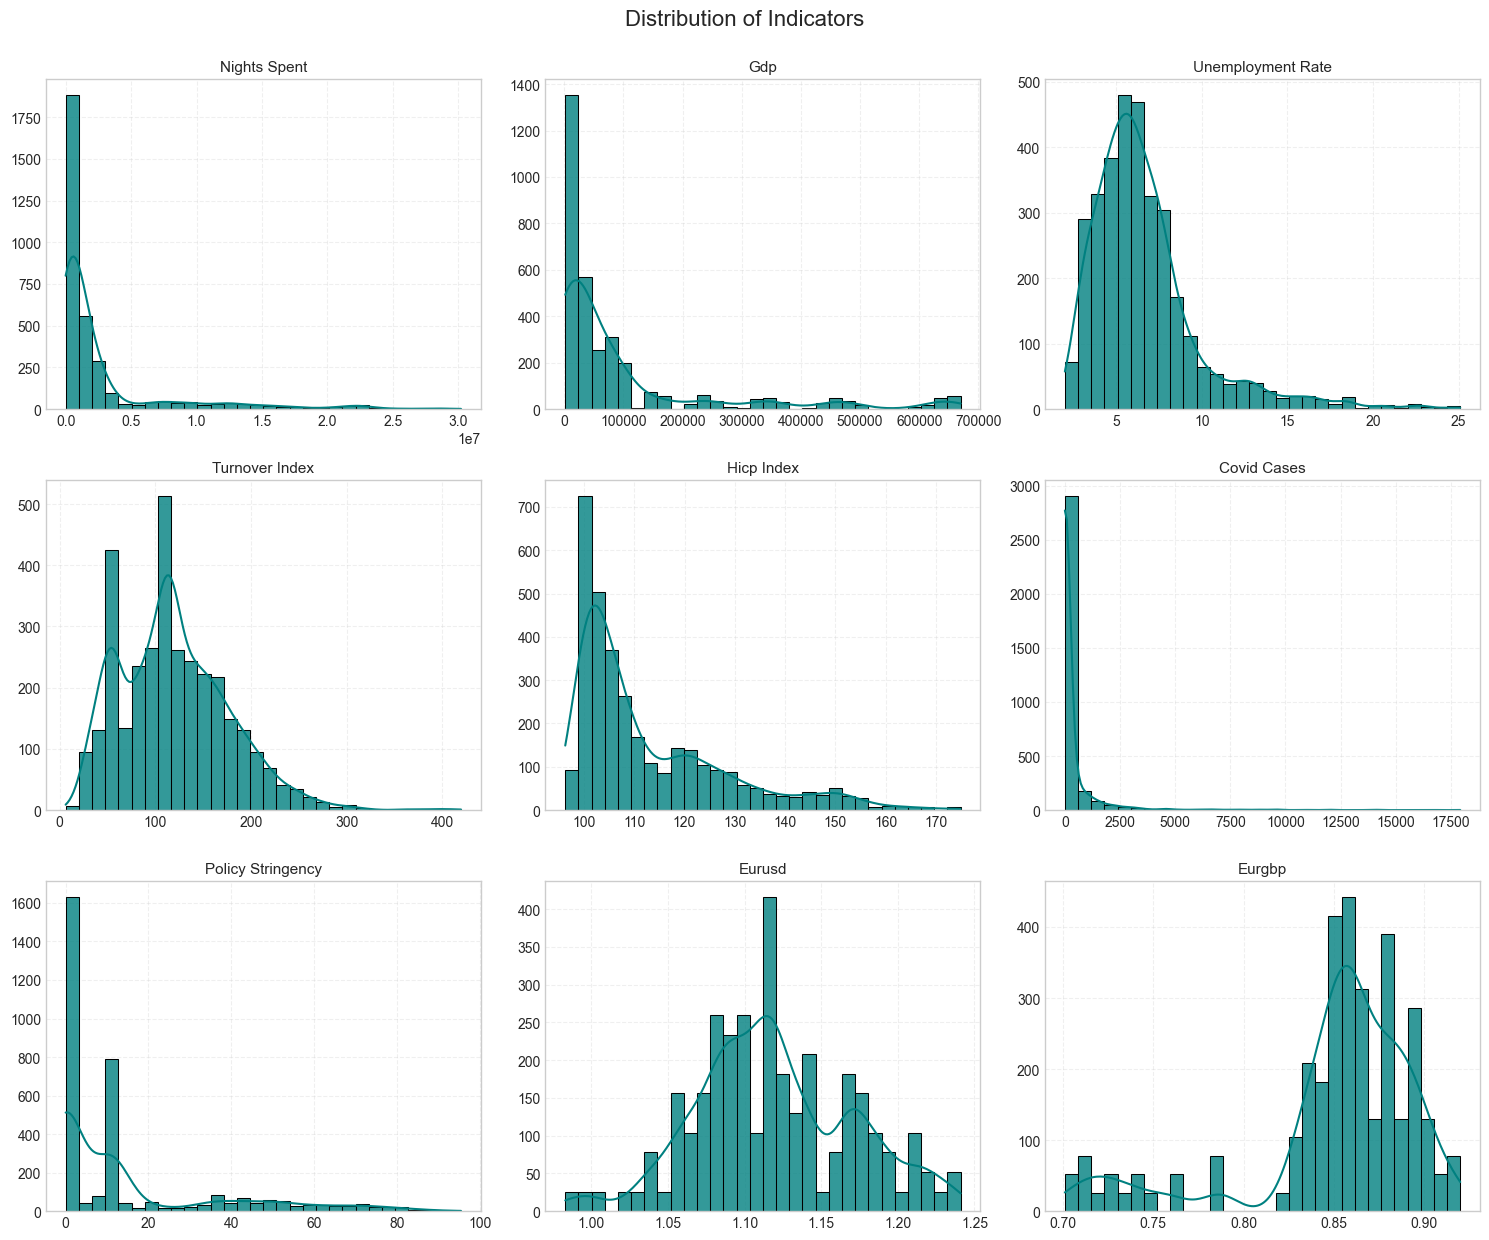

In [10]:
# %% ===============================================================
# STEP 5.4 — INDICATOR DISTRIBUTIONS
# ===============================================================

# --- Define numeric columns of interest ---
numeric_cols_all = [
    "nights_spent", "gdp", "unemployment_rate",
    "turnover_index", "hicp_index",
    "covid_cases", "policy_stringency",
    "eurusd", "eurgbp"
]

# --- Filter to columns present and valid ---
numeric_cols_all = [c for c in numeric_cols_all if c in df_clean.columns and df_clean[c].nunique() > 3]
print(f"[INFO] Plotting distributions for {len(numeric_cols_all)} numeric indicators.")

# --- Grid layout (3x3 since we have 9 plots) ---
n_cols = 3
n_rows = math.ceil(len(numeric_cols_all) / n_cols)

plt.figure(figsize=(n_cols * 5, n_rows * 4))

# --- Plot histograms ---
for i, col in enumerate(numeric_cols_all, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(
        x=df_clean[col].dropna(),
        kde=True,
        bins=30,
        color="teal",
        alpha=0.8,
    )
    plt.title(col.replace("_", " ").title(), fontsize=11)
    plt.xlabel("")
    plt.ylabel("")
    plt.grid(alpha=0.3, linestyle="--")

plt.tight_layout()
plt.suptitle("Distribution of Indicators", fontsize=16, y=1.03)
plt.show()

# --- Reuse this list for correlation analysis ---
numeric_cols_corr = numeric_cols_all

[INFO] Using 9 numeric variables for correlation analysis: ['nights_spent', 'gdp', 'unemployment_rate', 'turnover_index', 'hicp_index', 'covid_cases', 'policy_stringency', 'eurusd', 'eurgbp']
[INFO] Correlation comparison heatmap saved → /Users/golibsanaev/Library/CloudStorage/Dropbox/GitHub_gsanaev/forecasting-explaining-hotel-demand-in-eu/outputs/figures/correlation_heatmap_within_vs_raw.png


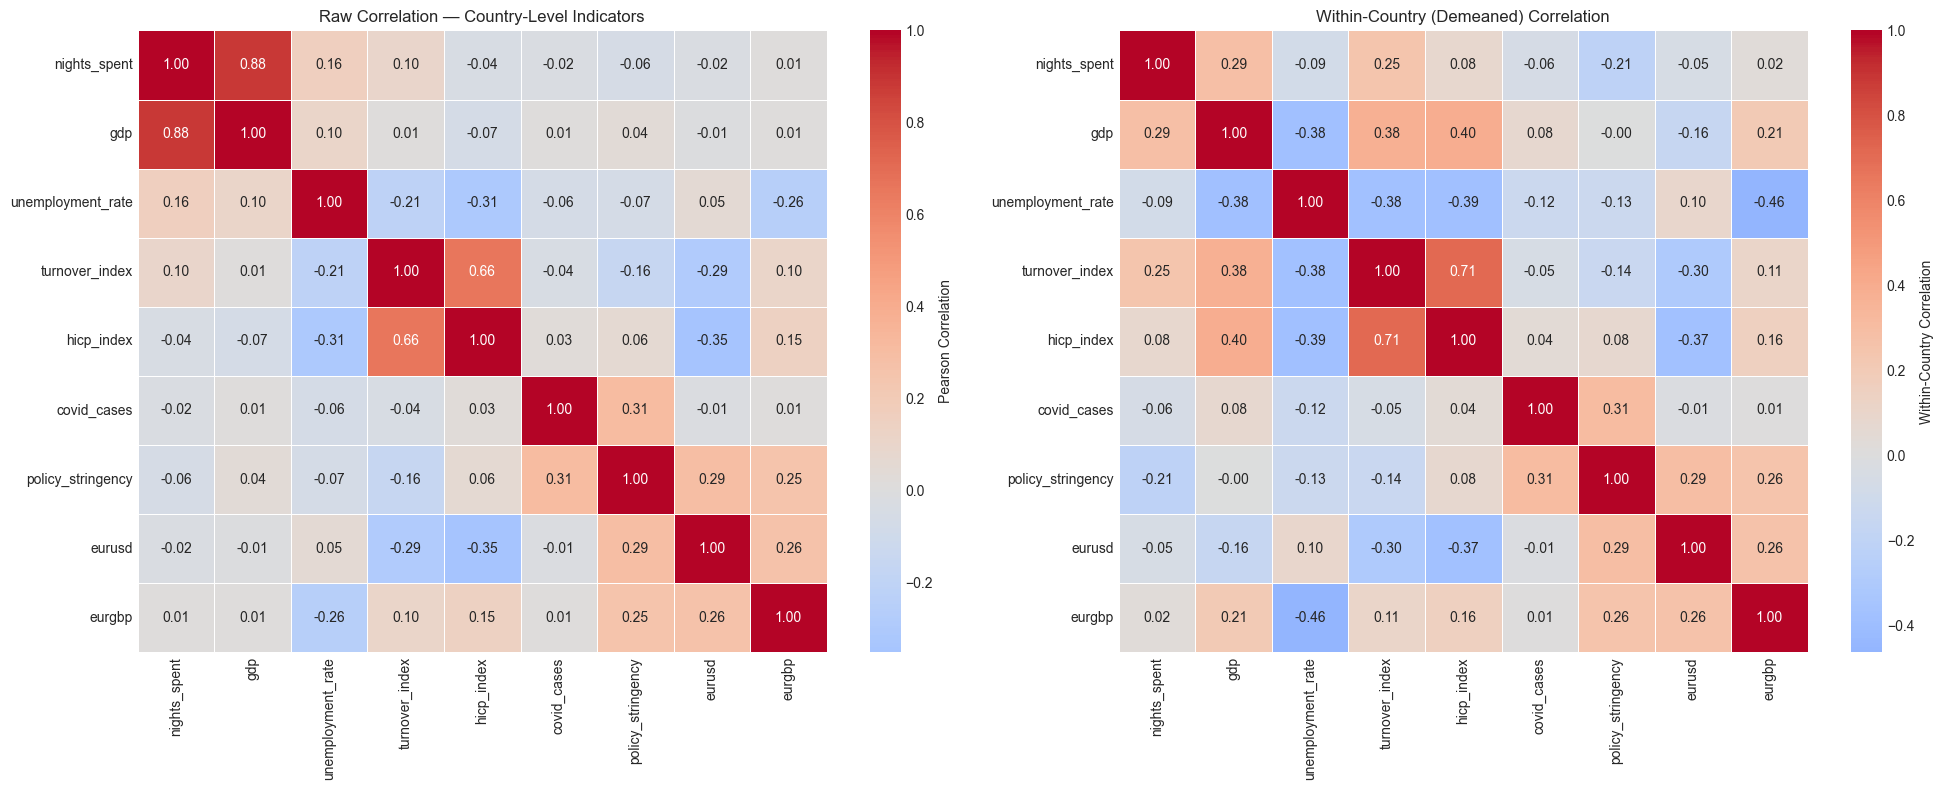

[INFO] Top within-country correlated indicators with nights spent:


,Within-Country Corr. with Nights Spent
nights_spent,1.000
gdp,0.287
turnover_index,0.249
hicp_index,0.083
eurgbp,0.024
eurusd,-0.050
covid_cases,-0.060
unemployment_rate,-0.086
policy_stringency,-0.210


In [11]:
# %% ===============================================================
# STEP 5.5 — CORRELATIONS AND FEATURE RELATIONSHIPS
# ===============================================================

# --- Define numeric columns of interest ---
numeric_cols = [
    "nights_spent", "gdp", "unemployment_rate",
    "turnover_index", "hicp_index",
    "covid_cases", "policy_stringency",
    "eurusd", "eurgbp"
]
corr_cols = [c for c in numeric_cols if c in df_clean.columns]
print(f"[INFO] Using {len(corr_cols)} numeric variables for correlation analysis: {corr_cols}")

# --- Compute Pearson correlation (raw) ---
corr_raw = df_clean[corr_cols].corr(method="pearson")

# --- Compute within-country (demeaned) correlation ---
df_demeaned = df_clean.copy()
for col in corr_cols:
    df_demeaned[col] = df_clean.groupby("region")[col].transform(lambda x: x - x.mean())
corr_within = df_demeaned[corr_cols].corr(method="pearson")

# --- Spearman (rank-based) correlation ---
corr_spearman = df_clean[corr_cols].corr(method="spearman")

# --- Visualization: side-by-side heatmaps ---
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

sns.heatmap(
    corr_raw, cmap="coolwarm", center=0, annot=True, fmt=".2f",
    cbar_kws={"label": "Pearson Correlation"}, linewidths=0.5, ax=axes[0]
)
axes[0].set_title("Raw Correlation — Country-Level Indicators")

sns.heatmap(
    corr_within, cmap="coolwarm", center=0, annot=True, fmt=".2f",
    cbar_kws={"label": "Within-Country Correlation"}, linewidths=0.5, ax=axes[1]
)
axes[1].set_title("Within-Country (Demeaned) Correlation")

plt.tight_layout()

# --- Save both heatmaps ---
save_path = FIGURES / "correlation_heatmap_within_vs_raw.png"
plt.savefig(save_path, dpi=300, bbox_inches="tight")
print(f"[INFO] Correlation comparison heatmap saved → {save_path.resolve()}")

plt.show()

# --- Identify top correlated indicators with hotel nights ---
top_corr = (
    corr_within["nights_spent"]
    .sort_values(ascending=False)
    .to_frame("Within-Country Corr. with Nights Spent")
    .round(3)
)
print("[INFO] Top within-country correlated indicators with nights spent:")
display(top_corr)

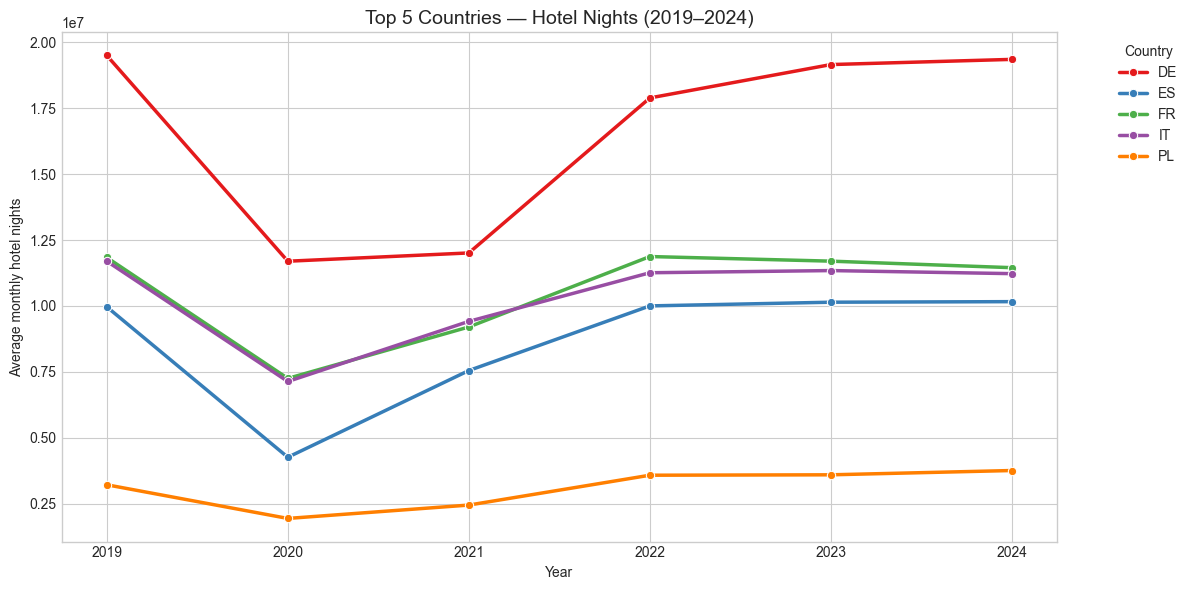

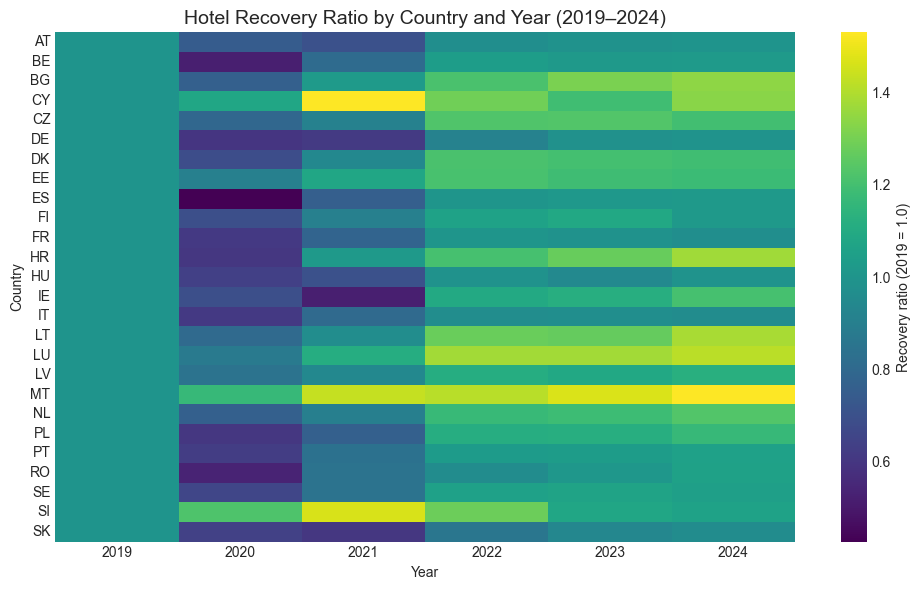

In [12]:
# %% ===============================================================
# STEP 5.6 — RECOVERY PATTERNS (2019 - 2024)
# ===============================================================

# Aggregate data by country (region) and year
recovery = (
    df_clean[df_clean["year"].between(2019, 2024)]
    .groupby(["region", "year"])["nights_spent"]
    .mean()
    .reset_index()
)

# Pivot → countries × years
recovery_pivot = recovery.pivot(index="region", columns="year", values="nights_spent")

# Normalize relative to 2019 baseline (Recovery ratio)
recovery_pivot = recovery_pivot.div(recovery_pivot[2019], axis=0)

# Fill any missing years (forward and backward)
recovery_pivot = recovery_pivot.ffill(axis=1).bfill(axis=1)

# --- Visualization 1: Country-level lines (Top 5 countries) ---
# Identify top 5 countries by mean hotel nights
top_regions = (
    recovery.groupby("region")["nights_spent"]
    .mean()
    .nlargest(5)
    .index
)

# Filter dataset
subset = recovery[recovery["region"].isin(top_regions)]

sns.set_palette("Set1")

# Plot
plt.figure(figsize=(12,6))
ax = sns.lineplot(
    data=subset,
    x="year", y="nights_spent", hue="region",
    estimator=None, linewidth=2.5, marker="o"
)
plt.title("Top 5 Countries — Hotel Nights (2019–2024)", fontsize=14)
plt.ylabel("Average monthly hotel nights")
plt.xlabel("Year")
ax.legend(
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    title="Country",
    frameon=False,
    ncol=1
)
plt.tight_layout()
plt.show()

# --- Visualization 2: Recovery ratio heatmap ---
plt.figure(figsize=(10,6))
sns.heatmap(
    recovery_pivot,
    cmap="viridis",
    cbar_kws={'label': 'Recovery ratio (2019 = 1.0)'}
)
plt.title("Hotel Recovery Ratio by Country and Year (2019–2024)", fontsize=14)
plt.ylabel("Country")
plt.xlabel("Year")
plt.tight_layout()
plt.show()

---

**Correlation Insights & Variable Rationale**

Exploratory correlation analysis revealed several key relationships:

- *High correlation* between `hicp_index` and `turnover_index` (≈ 0.71)  
  → Indicates overlapping information, both capturing price and business activity trends.  
  Because `turnover_index` directly reflects *actual revenue volume in tourism and services* (e.g., hotel sales, travel agency turnover) and has clearer economic meaning for demand, we retain `turnover_index` and drop `hicp_index`.

- *Moderate correlation* between `covid_cases` and `policy_stringency` (≈ 0.31)  
  → Suggests policy stringency already captures the behavioral and policy effects of COVID-19.  
  We therefore exclude `covid_cases` from the model (used only for EDA) to reduce redundancy.

- *Weighted Stringency Index (WSI)*  
  Following *Curtale et al. (2023)*, we replace the raw `policy_stringency` variable with a *Weighted Stringency Index (WSI)*, which adjusts for each region’s tourism seasonality.  
  This better represents how restrictions affected high-tourism months and reduces measurement-error bias.

- *Log transformations*  
  The distributions of `nights_spent` and `gdp` are strongly right-skewed across countries.  
  Log transformation improves normality, stabilizes variance, and enables elasticity interpretation (e.g., a 1 % increase in GDP → β % change in nights spent).  
  Other variables (turnover index, exchange rates, unemployment rate, stringency index) already have stable scales and remain in levels.

**Summary of decisions**

| Variable | Action | Reason |
|-----------|---------|--------|
| `nights_spent` | → `log(nights_spent)` | Skewed scale, interpret as % change |
| `gdp` | → `log(gdp)` | Skewed scale, income elasticity |
| `turnover_index` | keep (levels) | Sectoral activity indicator |
| `unemployment_rate` | keep (levels) | Bounded percentage |
| `policy_stringency` | → replace with WSI | Seasonally weighted restriction measure |
| `hicp_index` | drop | High correlation with turnover_index |
| `covid_cases` | drop (EDA only) | Moderate correlation, indirect effect |

These adjustments ensure interpretability, reduce multicollinearity, and align with best practice in tourism-econometrics literature.

> - Curtale, R., e Silva, F. B., Proietti, P., & Barranco, R. (2023). Impact of COVID-19 on tourism demand in European regions-An analysis of the factors affecting loss in number of guest nights. *Annals of Tourism Research Empirical Insights, 4*(2), 100112.

In [13]:
# %% ===============================================================
# STEP 6 — VARIABLE TRANSFORMATIONS
# ===============================================================
# Purpose: Create model-ready features by transforming skewed variables,
#          generating the Weighted Stringency Index (WSI),
#          and keeping only relevant, ordered columns.
# ===============================================================

# --- 1. Drop redundant variables (EDA-only)
drop_vars = ["hicp_index", "covid_cases", "period"]
df_clean = df_clean.drop(columns=[col for col in drop_vars if col in df_clean.columns], errors="ignore")  # type: ignore

# --- 1.5. Impute missing or zero values before log transformation ---
# Replace zero or missing nights_spent/gdp values with region-year median of positive values
for col in ["nights_spent", "gdp"]:
    if col in df_clean.columns:
        # Compute median per region-year (only positive values)
        medians = (
            df_clean[df_clean[col] > 0]
            .groupby(["region", "year"])[col]
            .median()
            .rename("median_positive")
        )

        # Merge medians back
        df_clean = df_clean.merge(medians, on=["region", "year"], how="left")

        # Apply imputation
        df_clean[col] = df_clean.apply(
            lambda x: x["median_positive"] if pd.isna(x[col]) or x[col] <= 0 else x[col],
            axis=1
        )

        # Drop helper column
        df_clean = df_clean.drop(columns="median_positive", errors="ignore")

# --- 2. Log-transform skewed variables safely
for col in ["nights_spent", "gdp"]:
    if (df_clean[col] <= 0).any():
        print(f"⚠️ Nonpositive values detected in {col} — filtering before log.")
        df_clean = df_clean[df_clean[col] > 0]
    df_clean[f"log_{col}"] = np.log(df_clean[col])

# --- 3. Compute tourism weights for 2019 (share of annual nights_spent per month)
df_clean["month_num"] = pd.to_datetime(df_clean["month"]).dt.month

weights_2019 = (
    df_clean[df_clean["year"] == 2019]
    .groupby(["region", "month_num"], as_index=False)["nights_spent"]
    .sum()
)
weights_2019["weight_2019"] = (
    weights_2019.groupby("region")["nights_spent"]
    .transform(lambda x: x / x.sum())
)
weights_2019 = weights_2019[["region", "month_num", "weight_2019"]]

# --- 4. Compute Weighted Stringency Index (WSI) for 2020
df_wsi = (
    df_clean.merge(weights_2019, on=["region", "month_num"], how="left")
    .query("year == 2020")
)

# Compute weighted index explicitly and reset index properly
wsi = (
    df_wsi.groupby("region", as_index=False)
    .apply(lambda g: pd.Series({"weighted_stringency_index": np.nansum(g["policy_stringency"] * g["weight_2019"])}))
    .reset_index(drop=True)
)

# --- 5. Merge WSI back into main DataFrame
df_clean = df_clean.merge(wsi, on="region", how="left")

# Fill across months (each region gets its WSI value for all periods)
df_clean["weighted_stringency_index"] = df_clean["weighted_stringency_index"].ffill().bfill()

# --- 6. Drop raw variables (keep model-ready versions)
drop_raw = ["nights_spent", "gdp", "policy_stringency", "month_num"]
df_clean = df_clean.drop(columns=[c for c in drop_raw if c in df_clean.columns], errors="ignore")

# --- 7. Reorder columns for clarity and consistency
ordered_cols = [
    "region", "month", "year",
    "log_nights_spent", "log_gdp",
    "unemployment_rate", "turnover_index",
    "weighted_stringency_index",
    "eurusd", "eurgbp"
]

# Keep only ordered columns that exist
df_clean = df_clean[[c for c in ordered_cols if c in df_clean.columns]]

# --- 8. Final checks
print("✅ Transformations complete — model-ready dataset created.")
print(f"🔹 Shape: {df_clean.shape}")

# --- 9. Summary statistics and missing values ---
display(df_clean.describe().T.round(2))

✅ Transformations complete — model-ready dataset created.
🔹 Shape: (3328, 10)


,count,mean,min,25%,50%,75%,max,std
month,3328,2020-04-16 04:52:30,2015-01-01 00:00:00,2017-08-24 06:00:00,2020-04-16 00:00:00,2022-12-08 18:00:00,2025-08-01 00:00:00,NaN
year,3328.0,2019.84375,2015.0,2017.0,2020.0,2022.25,2025.0,3.083779
log_nights_spent,3328.0,13.448233,5.147494,12.100265,13.631481,14.594523,17.22325,1.812738
log_gdp,3328.0,10.389341,7.427144,9.032616,10.493316,11.423246,13.415018,1.561698
unemployment_rate,3328.0,6.672386,2.0,4.6,6.0,7.7,25.1,3.238662
turnover_index,3328.0,119.759856,6.3,78.7,114.5,155.525,419.6,56.721679
weighted_stringency_index,3328.0,49.18058,36.617093,44.671611,48.849586,52.96561,65.876549,6.46075
eurusd,3328.0,1.118962,0.982956,1.084225,1.115387,1.157142,1.240957,0.051836
eurgbp,3328.0,0.849934,0.701,0.842647,0.859745,0.88004,0.9201,0.049174


In [14]:
# %% ===============================================================
# STEP 7 — SAVE CLEAN DATASET AND EDA SUMMARY
# ===============================================================
# Purpose: Export harmonized dataset for modeling and documentation
# ===============================================================

summary = {
    "total_countries": df_clean["region"].nunique(),
    "time_range": (
        df_clean["month"].min().strftime("%Y-%m"),
        df_clean["month"].max().strftime("%Y-%m")
    ),
    "missing_share": df_clean.isna().mean().round(4).to_dict(),
    "avg_log_hotel_nights": round(df_clean["log_nights_spent"].mean(), 2),
    "avg_log_gdp": round(df_clean["log_gdp"].mean(), 2),
    "min_year": int(df_clean["year"].min()),
    "max_year": int(df_clean["year"].max()),
}

summary_df = pd.DataFrame.from_dict(summary, orient="index", columns=["value"])
display(summary_df)

# --- Define export paths ---
CLEAN_PATH = DATA_PROCESSED / "hotel_clean.csv"

# --- Save files ---
df_clean.to_csv(CLEAN_PATH, index=False)

# --- Confirmation messages ---
print("💾 Data exports complete:")
print(f"   • Clean dataset → {CLEAN_PATH.resolve()}")

for path in [CLEAN_PATH]:
    if path.exists():
        size = path.stat().st_size / 1024
        print(f"✅ Verified: {path.name} ({size:.1f} KB)")       

,value
total_countries,26
time_range,"(2015-01, 2025-08)"
missing_share,"{'region': 0.0, 'month': 0.0, 'year': 0.0, 'lo..."
avg_log_hotel_nights,13.45
avg_log_gdp,10.39
min_year,2015
max_year,2025


💾 Data exports complete:
   • Clean dataset → /Users/golibsanaev/Library/CloudStorage/Dropbox/GitHub_gsanaev/forecasting-explaining-hotel-demand-in-eu/data/processed/hotel_clean.csv
✅ Verified: hotel_clean.csv (396.0 KB)


## ✅ Summary

Notebook 1 successfully completed.  
The cleaned and harmonized dataset is now ready for **feature engineering and lag creation** in **Notebook 2 — Feature Engineering for Hotel Demand Forecasting (2015–2025)**.

---